<a href="https://colab.research.google.com/github/KodakV/case_pochta1/blob/master/Model_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [478]:
# import
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import random
import seaborn as sns; sns.set()


from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn import decomposition
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering,AffinityPropagation,SpectralClustering
from sklearn import preprocessing
from sklearn import metrics
import datetime
from datetime import datetime
import time

In [479]:
# seed
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [480]:
# data
# df=pd.read_csv('/content/Батч 1.xlsx')

# batch_nornal - предобработанный бач данных, с нужными фичами
df=pd.read_csv('/content/Batch1_normal30.csv',parse_dates=True)
df=df.iloc[:50000,:]
data_property=['untreated','normal']

if df.shape[1]==26:
  flag=data_property[1]

In [481]:
# df_2=pd.read_excel('/content/select_p_hid_p_dt_p_sender_index_p_re (1).csv',parse_dates=True)

In [482]:
df.head(n=5)

,Unnamed: 0,Unnamed: 0.1,hid,data,sender_index,recipient_index,weight,cost,summa_OTS,summa_NP,blank_dispatch,parcel_post,accelerated,international,with_advert_value,with_imposition_payment,with_list_of_attachments,caution_mark,sms for sender,sms for recipient,ts,mean_user_cost,count_sum,max_data,ts_delta,sum_cost,activity,solvency
0,0,0,17279630-2e29-4a0d-8f96-f3c932e6bbcb,2020-07-05 00:00:26.036,109469,107241,100.0,173.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1593907226,173.0,3,1593908483,173,519.0,6.639367,0.811083
1,1,1,16971e43-728a-4f66-a93c-3678aa8433cd,2020-07-05 00:03:17.229,390039,125284,1100.0,238.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,1593907397,238.0,1,1593907397,238,238.0,2.743904,0.730362
2,2,2,16d739fa-ca72-4b12-b8a1-ae5d91df945f,2020-07-05 00:11:47.671,111250,670033,100.0,173.0,0.0,0.0,1,0,1,0,0,0,0,0,0,0,1593907907,183.5,2,1593979001,183,367.0,180.895936,0.814058
3,3,3,8182829,2020-07-05 00:12:50.965,105173,183035,2262.0,363.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1593907970,311.0,4,1593947921,311,1244.0,102.327526,1.066296
4,4,4,1645b790-f6f9-4c3f-b92b-eae34e781784,2020-07-05 00:13:05.474,195197,184209,1905.0,338.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1593907985,313.0,2,1593907985,313,626.0,2.402656,0.976841


In [483]:
# Подготовка данных, если загружаются сырые данные
if flag=='untreated':
  df.rename(columns={'дата оформления': 'data', 'индекс отправителя': 'sender_index',
                   'индекс получателя': 'recipient_index','вес (гр)': 'weight','стоимость (руб,коп)': 'cost',
                   'сумма ОЦ (руб)': 'summa_OTS', 'сумма НП (руб)':'summa_NP',
                   'безбланковая отправка':'blank_dispatch','бандероль':'parcel_post',
                   'ускоренное':'accelerated','международное':'international','с объявл. ценностью':'with_advert_value',
                   'с налож. платежом':'with_imposition_payment','с описью вложений':'with_list_of_attachments',
                   "отметка 'Осторожно'":'caution_mark','sms для отправителя':'sms for sender','sms для получателя':'sms for recipient'}, inplace=True)
  df=df.fillna(0)
  df["blank_dispatch"] = df["blank_dispatch"].astype(int)
  df["parcel_post"] = df["parcel_post"].astype(int)
  df["accelerated"] = df["accelerated"].astype(int)
  df["international"] = df["international"].astype(int)
  df["with_advert_value"] = df["with_advert_value"].astype(int)
  df["with_imposition_payment"] = df["with_imposition_payment"].astype(int)
  df["with_list_of_attachments"] = df["with_list_of_attachments"].astype(int)
  df["caution_mark"] = df["caution_mark"].astype(int)
  df["sms for sender"] = df["with_imposition_payment"].astype(int)
  df["sms for recipient"] = df["sms for recipient"].astype(int)
  df['data'] = pd.to_datetime(df['data'], errors='coerce')
  df['ts'] = df.data.values.astype(np.int64) // 10 ** 9
  df['mean_user_cost']=''
  df['count_sum']=''
  df['max_data']=''
  df['ts_delta']=''
  df['sum_cost']=''


In [484]:
if flag=='untreated':
  dict_count=df.groupby(['hid'])['data'].count().to_dict()
  dict_max_data=df.groupby(['hid'])['ts'].apply(list).apply(np.max).to_dict()
  dict_ts_delta=df.groupby('hid')['cost'].apply(list).apply(np.mean).apply(np.mean).to_dict()
  dict_mean_cost=df.groupby('hid')['cost'].apply(list).apply(np.mean).to_dict()
  dict_sum_cost=df.groupby('hid')['cost'].apply(list).apply(np.sum).to_dict()
  for i in df.hid:
    df.loc[df['hid']==i,'mean_user_cost']=dict_mean_cost[i]
    df.loc[df['hid']==i,'count_sum']=dict_count[i]
    df.loc[df['hid']==i,'max_data']=dict_max_data[i]
    df.loc[df['hid']==i,'ts_delta']=dict_ts_delta[i]
    df.loc[df['hid']==i,'sum_cost']=dict_sum_cost[i]
    
  df=df.replace('',0)
  df["mean_user_cost"] = df["mean_user_cost"].astype(float)
  df["count_sum"] = df["count_sum"].astype(int)
  df["max_data"] = df["max_data"].astype(int)
  df["ts_delta"] = df["ts_delta"].astype(int)
  df["sum_cost"] = df["sum_cost"].astype(float)


In [485]:
# создание метрик
if flag=='untreated':
  df['activity'] = df.count_sum/df.count_sum.mean() + df.ts_delta.mean()/df.ts_delta + ((df.max_data-df.ts)/df.ts_delta.mean()+1)
  df['solvency']=df.sum_cost/df.sum_cost.mean()+df.mean_user_cost/df.mean_user_cost.mean()+df.accelerated*0.2+df.with_advert_value+0.1+df.with_imposition_payment*0.1

In [486]:
df['solvency']=df.sum_cost/df.sum_cost.mean()+df.mean_user_cost/df.mean_user_cost.mean()+df.accelerated*0.2+df.with_advert_value+0.1+df.with_imposition_payment*0.1

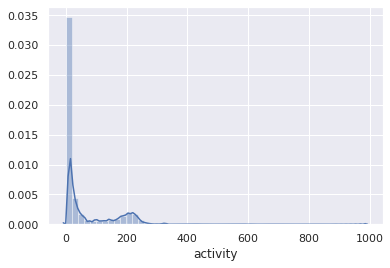

In [487]:
sns_plot = sns.distplot(df['activity'])
fig = sns_plot.get_figure()

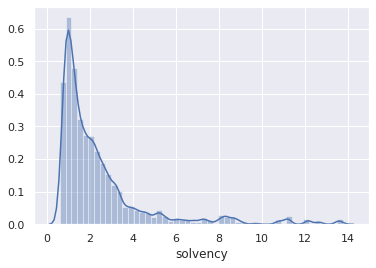

In [488]:
sns_plot = sns.distplot(df['solvency'])
fig = sns_plot.get_figure()

In [489]:
# Описание всего датасета
df.describe()

,Unnamed: 0,Unnamed: 0.1,sender_index,recipient_index,weight,cost,summa_OTS,summa_NP,blank_dispatch,parcel_post,accelerated,international,with_advert_value,with_imposition_payment,with_list_of_attachments,caution_mark,sms for sender,sms for recipient,ts,mean_user_cost,count_sum,max_data,ts_delta,sum_cost,activity,solvency
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.0,30000.000000,30000.0,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000
mean,14999.500000,14999.500000,378434.472200,413138.978367,1778.872267,400.680314,676.895033,575.976767,0.718533,0.0,0.181933,0.0,0.261367,0.142567,0.009933,0.004400,0.142567,0.093067,1.593997e+09,400.680314,16.178733,1.594013e+09,400.338600,6543.374654,44.457502,2.412010
std,8660.398374,8660.398374,207352.807352,201571.990938,2649.349722,270.425535,1914.970235,1792.621965,0.449722,0.0,0.385796,0.0,0.439387,0.349636,0.099172,0.066188,0.349636,0.290531,3.716182e+04,210.162520,29.071594,3.295150e+04,210.109513,12073.829355,76.070089,2.190836
min,0.000000,0.000000,101000.000000,101000.000000,0.000000,173.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.593907e+09,173.000000,1.000000,1.593907e+09,173.000000,173.000000,1.139515,0.613825
25%,7499.750000,7499.750000,153038.000000,196233.000000,300.000000,263.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.593961e+09,275.000000,2.000000,1.593989e+09,275.000000,792.000000,2.736820,1.079821
50%,14999.500000,14999.500000,367014.000000,400082.000000,800.000000,313.120000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.594016e+09,343.733333,6.000000,1.594029e+09,343.000000,2102.130000,6.567690,1.691876
75%,22499.250000,22499.250000,620076.500000,628611.000000,2000.000000,457.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.594030e+09,472.615385,15.000000,1.594034e+09,472.000000,5894.400000,34.799319,2.745752
max,29999.000000,29999.000000,694910.000000,694923.000000,20000.000000,5152.800000,45350.000000,45350.000000,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.594301e+09,5152.800000,177.000000,1.594301e+09,5152.000000,72182.390000,983.447934,13.765812


In [490]:
if flag=='untreated':
  df.to_csv('/content/Batch_normal.csv')

In [521]:
X_sourse=df.iloc[:30000,4:28]
# X_sourse=df.iloc[:10000,[4,5,6,7,8,9,10,23,22,21,20,19]]
# std and norl
# X_sourse=X_sourse.drop('ts',axis=1)
# X_sourse=X_sourse.drop('max_data',axis=1)
X = preprocessing.scale(X_sourse)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [522]:
pca = decomposition.PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

In [493]:
# если не жалко время, то можно и этот метод
#  t-SNE and PCA
# tsne = TSNE(random_state=17)
# X_tsne = tsne.fit_transform(X)

In [494]:
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s = 50);
# plt.show()

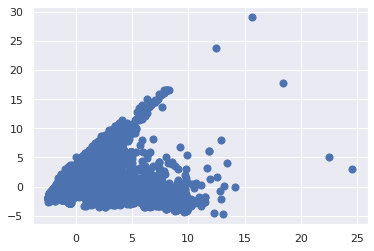

In [523]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], s = 50);
plt.show()

In [496]:
# algoritms
# подбор алгоритма  и сравнение их
# algorithms = []
# algorithms.append(KMeans(n_clusters = 2,n_init = 100,random_state=17 ))
# algorithms.append(AgglomerativeClustering(n_clusters = 2))
# algorithms.append(SpectralClustering(n_clusters=2, random_state=1,
#                                      affinity='nearest_neighbors'))
# # algorithms.append(DBSCAN(eps=0.1, min_samples=5))
# # algorithms.append(AffinityPropagation())

# data = []
# for algo in algorithms:
#     algo.fit(X)
#     print(algo)
#     data.append(({
#         # 'ARI': metrics.adjusted_rand_score(y, algo.labels_),
#         # 'AMI': metrics.adjusted_mutual_info_score(y, algo.labels_),
#         # 'Homogenity': metrics.homogeneity_score(y, algo.labels_),
#         # 'Completeness': metrics.completeness_score(y, algo.labels_),
#         # 'V-measure': metrics.v_measure_score(y, algo.labels_),
      
#         'Silhouette': metrics.silhouette_score(X, algo.labels_)}))
# results = pd.DataFrame(data=data, columns=['Silhouette'], index=['K-means', 'Agglomerative','Spectral'])
# results

In [497]:
#  подбор оптимального количества сегментов
# loss=[]
# for k in range(2, 10):
#     kmeans = KMeans(n_clusters=k,n_init = 100,random_state=1).fit(X)
#     loss_current=metrics.silhouette_score(X, kmeans.labels_)
#     loss.append(loss_current)

# plt.plot(range(2, 10), loss, marker='s');
# plt.xlabel('$k$')
# plt.ylabel('$J(C_k)$');

In [498]:
#  обучение моделей
kmeans = KMeans(n_clusters = 3,n_init = 100,random_state=17 ).fit(X)
sc = SpectralClustering(n_clusters=3, random_state=1, affinity='nearest_neighbors').fit(X)
ac2 = AgglomerativeClustering(n_clusters = 3).fit(X)
clustering = DBSCAN(eps=0.1, min_samples=5).fit(X)

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


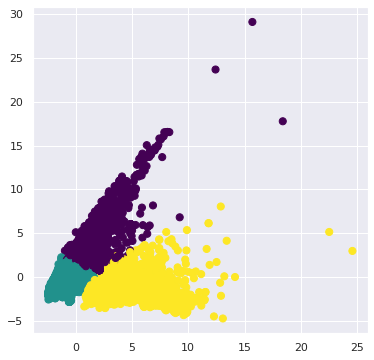

In [524]:
# KMeans
plt.figure(figsize =(6, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = kmeans.labels_, s = 50, cmap = 'viridis')

In [500]:
# красивый график для KMeans
# for i in range(0, X_pca.shape[0]):
#     if kmeans.labels_[i] == 0:
#         c1 = plt.scatter(X_pca[i, 0], X_pca[i, 1], c='r', marker='+')
#     elif kmeans.labels_[i] == 1:
#         c2 = plt.scatter(X_pca[i, 0], X_pca[i, 1], c='g', marker='o')
#     elif kmeans.labels_[i] == 2:
#         c3 = plt.scatter(X_pca[i, 0], X_pca[i, 1], c='b', marker='*')

# plt.legend([c1, c2, c3], ['Кластер 1', 'Кластер 2', 'Кластер 3'])
# plt.title('knn нашел 3 кластера')
# plt.show()

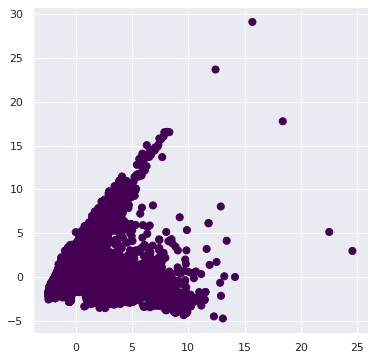

In [525]:
# sc
plt.figure(figsize =(6, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = sc.labels_, s = 50, cmap = 'viridis')

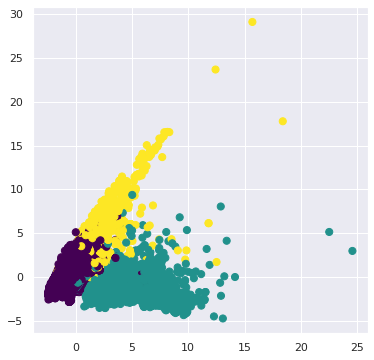

In [526]:
# ac2
plt.figure(figsize =(6, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = ac2.labels_, s = 50, cmap = 'viridis')


In [527]:
c = kmeans.labels_
first_class, = np.where(c == 0)
second_class, = np.where(c == 1)
third_class, = np.where(c == 2)


In [528]:
first_class=X_sourse.iloc[first_class,:]
second_class=X_sourse.iloc[second_class,:]
third_class=X_sourse.iloc[third_class,:]

In [529]:
first_class.describe()

,sender_index,recipient_index,weight,cost,summa_OTS,summa_NP,blank_dispatch,parcel_post,accelerated,international,with_advert_value,with_imposition_payment,with_list_of_attachments,caution_mark,sms for sender,sms for recipient,ts,mean_user_cost,count_sum,max_data,ts_delta,sum_cost,activity,solvency
count,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.0,4053.000000,4053.0,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4.053000e+03,4053.000000,4053.000000,4.053000e+03,4053.000000,4053.000000,4053.000000,4053.000000
mean,457578.448557,450307.865532,6620.120405,819.771098,386.952628,9.892672,0.901308,0.0,0.026400,0.0,0.333087,0.004935,0.004194,0.014804,0.004935,0.106588,1.594011e+09,731.799178,10.475204,1.594025e+09,731.407599,6816.698231,37.926599,3.307023
std,198800.733397,204072.109448,3893.196500,453.520125,1268.464426,257.410277,0.298285,0.0,0.160342,0.0,0.471375,0.070082,0.064636,0.120782,0.070082,0.308626,3.557216e+04,318.858795,17.356937,2.934785e+04,318.850442,10670.519912,73.835896,1.793648
min,105122.000000,101000.000000,14.000000,179.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.593907e+09,306.780000,1.000000,1.593908e+09,306.000000,312.070000,1.139515,1.005815
25%,309642.000000,243559.000000,4194.000000,550.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.594008e+09,536.705000,2.000000,1.594025e+09,536.000000,1472.800000,1.834946,2.162686
50%,453120.000000,445047.000000,6000.000000,682.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.594025e+09,641.666667,5.000000,1.594032e+09,641.000000,3191.000000,6.506429,2.859822
75%,650904.000000,655614.000000,8565.000000,947.000000,100.000000,0.000000,1.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.594031e+09,828.935211,10.000000,1.594035e+09,828.000000,6613.600000,28.666953,3.787966
max,694820.000000,694920.000000,20000.000000,5152.800000,20000.000000,12950.000000,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.594301e+09,5152.800000,146.000000,1.594301e+09,5152.000000,58854.400000,720.948154,13.747611


In [530]:
second_class.describe()

,sender_index,recipient_index,weight,cost,summa_OTS,summa_NP,blank_dispatch,parcel_post,accelerated,international,with_advert_value,with_imposition_payment,with_list_of_attachments,caution_mark,sms for sender,sms for recipient,ts,mean_user_cost,count_sum,max_data,ts_delta,sum_cost,activity,solvency
count,21675.000000,21675.000000,21675.000000,21675.000000,21675.000000,21675.0,21675.000000,21675.0,21675.000000,21675.0,21675.000000,21675.0,21675.000000,21675.000000,21675.0,21675.000000,2.167500e+04,21675.000000,21675.000000,2.167500e+04,21675.000000,21675.000000,21675.000000,21675.000000
mean,377482.558708,396376.174533,1025.122814,302.326746,53.289735,0.0,0.676678,0.0,0.205352,0.0,0.102376,0.0,0.001384,0.002907,0.0,0.081569,1.593995e+09,322.173983,13.019885,1.594011e+09,321.873725,4107.916997,41.960512,1.675312
std,201555.215822,200455.702306,1186.606660,96.561964,350.671905,0.0,0.467755,0.0,0.403968,0.0,0.303149,0.0,0.037178,0.053835,0.0,0.273713,3.705074e+04,96.257247,25.780286,3.319904e+04,96.197110,7831.580544,73.572103,1.269822
min,101000.000000,101000.000000,0.000000,173.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.593907e+09,173.000000,1.000000,1.593907e+09,173.000000,173.000000,1.608878,0.613825
25%,162512.000000,188640.000000,230.000000,238.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.593959e+09,260.667619,2.000000,1.593984e+09,260.000000,626.000000,2.743904,0.969716
50%,367014.000000,390511.000000,579.000000,288.000000,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.594008e+09,302.312500,5.000000,1.594028e+09,302.000000,1554.080000,5.479982,1.287773
75%,614064.000000,624182.500000,1222.000000,342.000000,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.594030e+09,372.249412,12.000000,1.594034e+09,372.000000,4052.020000,28.951457,1.939786
max,694910.000000,694923.000000,8974.000000,1200.000000,11000.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.594301e+09,825.700000,177.000000,1.594301e+09,825.000000,56467.090000,983.447934,10.694919


In [532]:
third_class.describe()

,sender_index,recipient_index,weight,cost,summa_OTS,summa_NP,blank_dispatch,parcel_post,accelerated,international,with_advert_value,with_imposition_payment,with_list_of_attachments,caution_mark,sms for sender,sms for recipient,ts,mean_user_cost,count_sum,max_data,ts_delta,sum_cost,activity,solvency
count,4272.000000,4272.000000,4272.000000,4272.000000,4272.000000,4272.000000,4272.000000,4272.0,4272.000000,4272.0,4272.0,4272.000000,4272.000000,4272.000000,4272.000000,4272.000000,4.272000e+03,4272.000000,4272.000000,4.272000e+03,4272.000000,4272.000000,4272.000000,4272.000000
mean,308177.493914,462925.559223,1010.131788,502.093853,4115.982444,4035.395131,0.757491,0.0,0.210674,0.0,1.0,0.996489,0.058755,0.002107,0.996489,0.138577,1.593993e+09,484.856332,37.617041,1.594017e+09,484.351592,18640.931831,63.322675,5.300692
std,217842.357907,191700.929461,1435.317728,212.493604,3118.236038,2924.083161,0.428651,0.0,0.407835,0.0,0.0,0.059158,0.235193,0.045856,0.059158,0.345545,3.639846e+04,156.035611,41.671299,3.219992e+04,156.032719,20690.438487,87.039983,3.258402
min,101000.000000,101000.000000,1.000000,204.450000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.593907e+09,184.828571,1.000000,1.593908e+09,184.000000,207.430000,1.241173,1.749395
25%,115446.000000,344015.750000,332.250000,369.037500,2090.000000,2055.250000,1.000000,0.0,0.000000,0.0,1.0,1.000000,0.000000,0.000000,1.000000,0.000000,1.593964e+09,382.221250,6.000000,1.593991e+09,382.000000,2463.830000,4.669011,2.784591
50%,190005.000000,450112.000000,500.000000,458.435000,3429.500000,3390.000000,1.000000,0.0,0.000000,0.0,1.0,1.000000,0.000000,0.000000,1.000000,0.000000,1.593991e+09,463.725714,20.000000,1.594032e+09,463.000000,10369.650000,17.317184,4.145265
75%,601782.000000,652056.500000,1000.000000,576.660000,5300.000000,5290.000000,1.000000,0.0,0.000000,0.0,1.0,1.000000,0.000000,0.000000,1.000000,0.000000,1.594030e+09,534.684370,54.000000,1.594036e+09,534.000000,27376.630000,115.410049,6.838384
max,692922.000000,694920.000000,17950.000000,3658.680000,45350.000000,45350.000000,1.000000,0.0,1.000000,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.594204e+09,2232.840000,146.000000,1.594204e+09,2232.000000,72182.390000,618.266662,13.765812


In [508]:
# считаем суммы
# third_class.describe().loc['count','cost']*third_class.describe().loc['mean','sum_cost']

In [509]:
# sns_plot = sns.distplot(third_class['sum_cost'])
# fig = sns_plot.get_figure()


In [556]:
df_metrics=first_class.loc[:,['solvency','activity']]
df_metrics_normalize = preprocessing.MinMaxScaler(df_metrics)
# df_metrics_normalize= preprocessing.scale(df_metrics)

In [539]:
df_metrics.head()


,solvency,activity
5,4.059230,1.406944
23,3.612685,1.443123
60,3.612685,3.176656
64,4.059230,2.663381
118,3.252145,26.231285


In [558]:
df_metrics_normalize

MinMaxScaler(copy=True,
             feature_range=       solvency   activity
5      4.059230   1.406944
23     3.612685   1.443123
60     3.612685   3.176656
64     4.059230   2.663381
118    3.252145  26.231285
...         ...        ...
29973  2.592237   1.772891
29982  1.720932   1.715958
29985  1.782245   1.790850
29992  4.323428   1.312963
29994  2.038329   1.983018

[4053 rows x 2 columns])

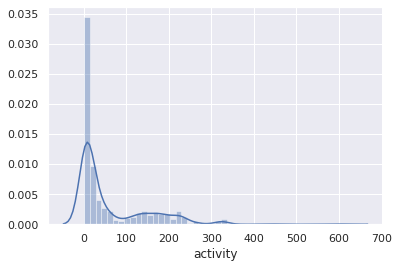

In [548]:
sns_plot = sns.distplot(third_class['activity'])
fig = sns_plot.get_figure()

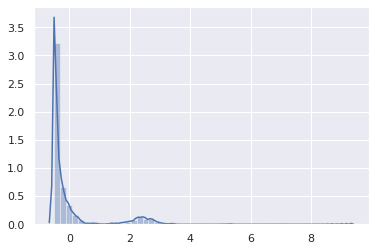

In [555]:
sns_plot = sns.distplot(df_metrics_normalize[:,1])
fig = sns_plot.get_figure()

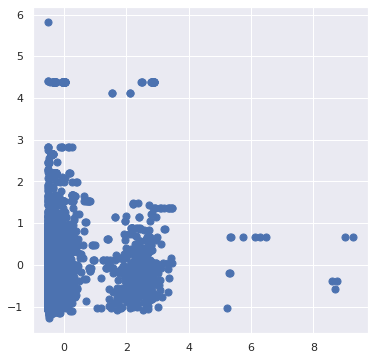

In [550]:
# распределение активности и платежеспособности 
plt.figure(figsize =(6, 6))
plt.scatter(df_metrics_normalize[:,1], df_metrics_normalize[:,0], s = 50, cmap = 'viridis', )

In [534]:
first_class.to_csv('first_class.csv')
second_class.to_csv('second_class.csv')
third_class.to_csv('third_class.csv')